In [3]:
# %pwd  #look at the current work dir
%cd ..
%pwd

/home/felix/projects/energy-aware-computing


'/home/felix/projects/energy-aware-computing'

In [4]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import pandas as pd
import json

class BenchmarkRun:
    def __init__(self, path):
        self.path = path
        self.name = self.path.name
        
    def __str__(self):
        return f"BenchmarkRun({self.name})"
    
    def __repr__(self):
        return self.__str__()
    
    @property
    def files(self):
        return list(self.path.glob("*"))
    
    @property
    def timestamps(self):
        return pd.read_csv(self.path / "timestamps.csv")
    
    @property
    def slow_data(self):
        return pd.read_csv(self.path / "gpu-power.csv", index_col=0)
    
    @property
    def system_info(self):
        with open(self.path / "system_info.json", "r") as f:
            return json.load(f)
    
    @property
    def power_samples(self):
        return pd.read_csv(self.path / "total_power_samples.csv",index_col=0)

class Benchmark:
    def __init__(self, path):
        self.path=path
        self.name = self.path.name
    
    def __str__(self):
        return f"Benchmark({self.name})"
    
    def __repr__(self):
        return self.__str__()
    
    @property
    def runs(self):
        return [BenchmarkRun(x) for x in self.path.glob("*")]

class Experiment:
    def __init__(self, data_root):
        self.data_root = Path(data_root)
        self.experiment_path = list(self.data_root.glob("*"))[0]
        self.name = self.experiment_path.name
        self.benchmarks = self.load_benchmarks()
    
    def load_benchmarks(self):
        return [Benchmark(x) for x in self.experiment_path.glob("*")]

In [4]:
from src.util import TimestampInfo
from src.new_analysis import *

In [8]:
ps = Experiment("data/dgx/").benchmarks[0].runs[0].power_samples

KeyError: 0

In [5]:
run = Experiment("../data/playground/").benchmarks[1].runs[2]
s = run.slow_data
ps = run.power_samples
s["power"] = s["power"] / 1000
ps["value"] = ps["value"] / 1000
ps["timestamp"] = (ps["timestamp"] - ps["timestamp"].iloc[0]) / 1_000_000
s["timestamp"] = pd.to_datetime(s["timestamp"])
s["timestamp"] = (s["timestamp"] - s["timestamp"].iloc[0]) /1000
#ts = run.timestamps
#ts["timestamp"] = pd.to_datetime(ts["timestamp"])

In [6]:
run.system_info

{'device_name': 'Tesla K20Xm',
 'cuda_capability': [3, 5],
 'driver_version': '440.33.01',
 'cuda_version': [10, 2],
 'nvml_version': '10.440.33.01',
 'platform': 'Linux-4.15.0-72-generic-x86_64-with-Ubuntu-18.04-bionic',
 'os_release': '4.15.0-72-generic',
 'os_version': '#81-Ubuntu SMP Tue Nov 26 12:20:02 UTC 2019',
 'machine': 'x86_64',
 'distro': {'distributor_id': 'Ubuntu',
  'description': 'Ubuntu 18.04.3 LTS',
  'release': '18.04',
  'codename': 'bionic'},
 'python_version': '3.6.9 (default, Jul 17 2020, 12:50:27) \n[GCC 8.4.0]',
 'pip_packages': [['zipp', '3.1.0'],
  ['wrapt', '1.12.1'],
  ['Werkzeug', '1.0.1'],
  ['webencodings', '0.5.1'],
  ['wcwidth', '0.2.5'],
  ['urllib3', '1.25.10'],
  ['traitlets', '4.3.3'],
  ['tornado', '6.0.4'],
  ['toml', '0.10.1'],
  ['threadpoolctl', '2.1.0'],
  ['testpath', '0.4.4'],
  ['terminado', '0.8.3'],
  ['termcolor', '1.1.0'],
  ['tensorflow-gpu', '2.3.0'],
  ['tensorflow-estimator', '2.3.0'],
  ['tensorboard', '2.3.0'],
  ['tensorboard-pl

<AxesSubplot:>

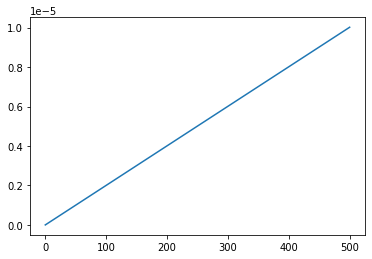

In [167]:
((ps.timestamp -ps.timestamp.iloc[0])/1_000_000).plot()

In [168]:

ts_arr = np.array(ts[ts["event"] == "epoch_begin"].timestamp - ts[ts["event"] == "epoch_begin"].iloc[0].timestamp)
ts_arr

array([         0, 2080800000, 3353703000, 4625228000],
      dtype='timedelta64[ns]')

In [169]:
#ps[["timestamp", "value"]].plot()

vline = [hv.VLine(t) for t in ts_arr]

p = ps.set_index("timestamp").hvplot()
p

:Curve   [timestamp]   (value)

In [170]:
s.set_index("timestamp").power.hvplot()

:Curve   [timestamp]   (power)

In [101]:
hv.help(hv.VLine)

VLine

Online example: http://holoviews.org/reference/elements/bokeh/VLine.html

-------------
Style Options
-------------

	alpha, color, hover_alpha, hover_color, hover_line_alpha, hover_line_color, level, line_alpha, line_cap, line_color, line_dash, line_join, line_width, muted_alpha, muted_color, muted_line_alpha, muted_line_color, nonselection_alpha, nonselection_color, nonselection_line_alpha, nonselection_line_color, selection_alpha, selection_color, selection_line_alpha, selection_line_color, visible

(Consult bokeh's documentation for more information.)

------------
Plot Options
------------

The plot options are the parameters of the plotting class:

Parameters of 'LineAnnotationPlot'

Parameters changed from their default values are marked in red.
Soft bound values are marked in cyan.
C/V= Constant/Variable, RO/RW = ReadOnly/ReadWrite, AN=Allow None

Name                                 Value                         Type         Bounds     Mode  

active_tools              

In [1]:
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np
from dtw import dtw, accelerated_dtw
import hvplot.pandas
import holoviews as hv

In [11]:
# plt.plot(sig.correlate(s.power, ps.value))
a = np.array(s.power)
b = np.array(ps.value)

In [12]:
alignment = dtw(a, b, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

TypeError: dtw() got an unexpected keyword argument 'keep_internals'

In [15]:
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(a,b, dist='euclidean')

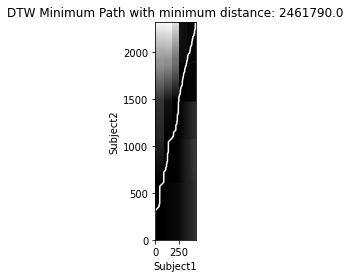

In [16]:

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('Subject1')
plt.ylabel('Subject2')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
plt.show()

In [163]:
!pip3 uninstall dtw-python -y

Found existing installation: dtw-python 1.1.5
Uninstalling dtw-python-1.1.5:
  Successfully uninstalled dtw-python-1.1.5


In [164]:
!pip3 install dtw

Using legacy setup.py install for dtw, since package 'wheel' is not installed.
    Running setup.py install for dtw ... done
You should consider upgrading via the '/home/felix/projects/energy-aware-computing/venv/bin/python3 -m pip install --upgrade pip' command.


In [42]:
!pip3 install hvplot

     |████████████████████████████████| 3.0 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.2 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 8.8 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 70 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 68 kB 3.0 MB/s eta 0:00:01
Using legacy setup.py install for bokeh, since package 'wheel' is not installed.
    Running setup.py install for bokeh ... done
You should consider upgrading via the '/home/felix/projects/energy-aware-computing/venv/bin/python3 -m pip install --upgrade pip' command.


In [5]:
from src.util import TimestampInfo
from src.new_analysis import *
import hvplot
import holoviews as hv
from bokeh.models import HoverTool

In [6]:
experiment = Experiment("data/dgx3")
# w150 = experiment.benchmarks["mnist"].runs["150W"]
experiment

Experiment(power-limit)

In [7]:
experiment.benchmarks["resnet"].runs["877MHz,502MHz"][0]

KeyError: '877MHz,502MHz'

In [8]:
p0 = experiment.benchmarks["mnist"].runs["150W"][0]._load_hd_power()
p1 = experiment.benchmarks["mnist"].runs["150W"][1].power_hd

In [9]:
p0.set_index("timestamp").resample("20ms").mean().power.hvplot()

:Curve   [timestamp]   (power)

In [10]:
p0.power.hvplot()

:Curve   [index]   (power)

In [11]:
p0.set_index("timestamp").join(p1.set_index("timestamp"), how='outer', rsuffix='_1').resample(1)

ValueError: Invalid frequency: 1

In [12]:
w1500 = experiment.benchmarks["mnist"].runs["235W"][0].data_sd["power-state"].hvplot()

In [13]:
w1500

:Curve   [index]   (power-state)

In [14]:
experiment = Experiment("data/dgx4")
e3 = Experiment("data/dgx3")

In [15]:
np.trapz(experiment.benchmarks["resnet"].runs["877MHz,502MHz"][0].power_hd.power,
        experiment.benchmarks["resnet"].runs["877MHz,502MHz"][0].power_hd.timestamp) - experiment.benchmarks["resnet"].runs["877MHz,502MHz"][0].power_hd.energy.iloc[-1]

6.821210263296962e-12

In [16]:
from collections import namedtuple
a = (e3.benchmarks["resnet"].runs["150W"][0].power_hd.iloc[-1])

In [17]:
w150 = e3.benchmarks["resnet"]
means = w150.get_total_values(aggregate=np.mean)

In [18]:
(-((means - means.iloc[4]) ).set_index("timestamp").energy).hvplot()
#means.iloc[4])

:Curve   [timestamp]   (energy)

In [19]:

experiment.benchmarks["mnist"].boxplot("energy")
#boxplot = df.hvplot.box(y='energy', by='run', height=450, width=800, legend=True)
#boxplot

:BoxWhisker   [run]   (energy)

In [23]:
(experiment.benchmarks["resnet"]
     .plot(metric="edp",data_slice=3)
     .opts(width=800, height=450,legend_position='bottom_right')
     #, legend_offset=(10, 50))
)

:Overlay
   .Curve.A_877MHz_comma_135MHz  :Curve   [timestamp]   (edp)
   .Curve.A_877MHz_comma_502MHz  :Curve   [timestamp]   (edp)
   .Curve.A_877MHz_comma_1005MHz :Curve   [timestamp]   (edp)
   .Curve.A_877MHz_comma_1530MHz :Curve   [timestamp]   (edp)

In [21]:
(experiment.benchmarks["resnet"]
     .plot_raw_power(data_slice=3)
     .opts(width=800, height=300,legend_position='bottom_right')
     #, legend_offset=(10, 50))
)

:Overlay
   .Curve.A_877MHz_comma_135MHz  :Curve   [timestamp]   (power)
   .Curve.A_877MHz_comma_502MHz  :Curve   [timestamp]   (power)
   .Curve.A_877MHz_comma_1005MHz :Curve   [timestamp]   (power)
   .Curve.A_877MHz_comma_1530MHz :Curve   [timestamp]   (power)

In [35]:
(experiment.benchmarks["resnet"]
     .plot_energy(data_slice=3)
     .opts(width=800, height=300,legend_position='bottom_right')
     #, legend_offset=(10, 50))
)*(e3.benchmarks["resnet"]
     .plot_energy(data_slice=3)
     .opts(width=800, height=300,legend_position='bottom_right')
  )

:Overlay
   .Curve.A_877MHz_comma_502MHz  :Curve   [timestamp]   (energy)
   .Curve.A_877MHz_comma_1005MHz :Curve   [timestamp]   (energy)
   .Curve.A_877MHz_comma_135MHz  :Curve   [timestamp]   (energy)
   .Curve.A_877MHz_comma_1530MHz :Curve   [timestamp]   (energy)
   .Curve.A_150W                 :Curve   [timestamp]   (energy)
   .Curve.A_235W                 :Curve   [timestamp]   (energy)
   .Curve.A_200W                 :Curve   [timestamp]   (energy)
   .Curve.A_300W                 :Curve   [timestamp]   (energy)
   .Curve.A_250W                 :Curve   [timestamp]   (energy)

In [87]:
w150 = experiment.benchmarks["mnist"].runs["150W"]#.repetitions[0]

In [72]:
w150[0].plot_raw_power() * w150[1].plot_raw_power()

:Overlay
   .Curve.A_150W.I  :Curve   [timestamp]   (energy)
   .Curve.A_150W.II :Curve   [timestamp]   (energy)

In [37]:
for epoch in w150.timestamps.epochs:
    print(epoch)
    hv.VLine(epoch.begin)

Epoch(index=0, begin=Timestamp('2020-09-03 15:16:21.504868'), end=Timestamp('2020-09-03 15:16:23.750261'))
Epoch(index=1, begin=Timestamp('2020-09-03 15:16:23.751882'), end=Timestamp('2020-09-03 15:16:25.263661'))
Epoch(index=2, begin=Timestamp('2020-09-03 15:16:25.265396'), end=Timestamp('2020-09-03 15:16:26.515228'))
Epoch(index=3, begin=Timestamp('2020-09-03 15:16:26.516834'), end=Timestamp('2020-09-03 15:16:27.761355'))


w150.power_hd["energy"] = get_energy(w150.power_hd.power, w150.power_hd.timestamp)

In [88]:
plots = []
for key, run in experiment.benchmarks["resnet"].runs.items():
    plot = run[0].power_hd.set_index("timestamp").energy.hvplot(label=key)
    plots.append(plot)
    #for epoch in run.timestamps.epochs:
    
    #    plot *= hv.VLine((epoch.begin-run.start_index)/np.timedelta64(1, 's'))
#     if plots is None:
#         plots = plot
#     else:
#         plots *= plot
overlay_plots(plots)

:Overlay
   .Curve.A_150W :Curve   [timestamp]   (energy)
   .Curve.A_200W :Curve   [timestamp]   (energy)
   .Curve.A_235W :Curve   [timestamp]   (energy)
   .Curve.A_250W :Curve   [timestamp]   (energy)
   .Curve.A_300W :Curve   [timestamp]   (energy)

In [357]:
batches = run.timestamps.timestamps[run.timestamps.timestamps["event"] == "batch_begin"].groupby("data").apply(lambda df: df.reset_index(drop=True)).swaplevel(0,1).loc[0]
batches["timestamp"] = (batches["timestamp"] -run.start_index)/np.timedelta64(1, 's')
batches

timestamp        event  data
data                              
0      0.019764  batch_begin     0
1      0.776964  batch_begin     1
2      0.779333  batch_begin     2
3      0.781657  batch_begin     3
4      0.784390  batch_begin     4
...         ...          ...   ...
464    1.830557  batch_begin   464
465    1.832726  batch_begin   465
466    1.834950  batch_begin   466
467    1.837173  batch_begin   467
468    1.839413  batch_begin   468

[469 rows x 3 columns]

In [359]:
plots = None
for key, run in experiment.benchmarks["resnet"].runs.items():
    plot = run.power_hd.set_index("timestamp").power.hvplot(label=key)
    for epoch in run.timestamps.epochs:
        plot *= hv.VLine(run.normalize_timestamp(epoch.begin))
    #plot *= hv.VLine(run.normalize_timestamp(run.timestamps.experiment_begin))
    #for batch in batches.itertuples():
    #    plot *= hv.VLine(batch.timestamp)
    if plots is None:
        plots = plot
    else:
        plots *= plot
plots

:Overlay
   .Curve.A_150W :Curve   [timestamp]   (power)
   .VLine.I      :VLine   [x,y]
   .VLine.II     :VLine   [x,y]
   .Curve.A_235W :Curve   [timestamp]   (power)
   .VLine.III    :VLine   [x,y]
   .VLine.IV     :VLine   [x,y]
   .Curve.A_200W :Curve   [timestamp]   (power)
   .VLine.V      :VLine   [x,y]
   .VLine.VI     :VLine   [x,y]
   .Curve.A_300W :Curve   [timestamp]   (power)
   .VLine.VII    :VLine   [x,y]
   .VLine.VIII   :VLine   [x,y]
   .Curve.A_250W :Curve   [timestamp]   (power)
   .VLine.IX     :VLine   [x,y]
   .VLine.X      :VLine   [x,y]

In [100]:
w150.power_hd["timestamp"] = (w150.power_hd.timestamp - w150.get_start_index())/ np.timedelta64(1, 's')

In [92]:
w150.power_hd = w150.power_hd.set_index("timestamp")

In [170]:
w150.power_hd

timestamp    power  energy
0            NaN   55.429     0.0
1            NaN   55.429     NaN
2            NaN   55.347     NaN
3            NaN   55.331     NaN
4            NaN   55.347     NaN
...          ...      ...     ...
7088  108.812477  125.427     NaN
7089  108.827769  128.968     NaN
7090  108.843287  123.240     NaN
7091  108.858704  128.290     NaN
7092  108.874003  128.097     NaN

[7093 rows x 3 columns]

In [103]:
w150.data_sd.timestamp - w150.data_sd.timestamp.iloc[10]

0     -1 days +23:59:58.866926
1     -1 days +23:59:59.000086
2     -1 days +23:59:59.124929
3     -1 days +23:59:59.275121
4     -1 days +23:59:59.319563
                ...           
427     0 days 00:00:43.317597
428     0 days 00:00:43.467734
429     0 days 00:00:43.510957
430     0 days 00:00:43.661098
431     0 days 00:00:43.706387
Name: timestamp, Length: 432, dtype: timedelta64[ns]